In [165]:
#Import libraries
library(ggplot2) # Data visualization
library(RSQLite)
library(plyr)
library(dplyr, warn.conflicts = FALSE)

#Connect to the database 
db <- dbConnect(SQLite(),"~/Downloads/soccer/database.sqlite")
Country <- dbGetQuery(db,"Select * from Country")
Match <- dbGetQuery(db,"Select * from Match")
League <- dbGetQuery(db,"Select * from League")
Team <- dbGetQuery(db,"Select * from Team")

skill_stats <- c(
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'free_kick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'balance',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'aggression',
    'interceptions',
    'positioning',
    'vision',
    'penalties',
    'marking',
    'standing_tackle',
    'sliding_tackle',
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_positioning',
    'gk_reflexes'
)

attributes <- c(
    'player_name',
    'date',
    'Player.player_fifa_api_id',
    'Player.player_api_id',
    'height',
    'weight',
    'overall_rating',
    'preferred_foot',
    'attacking_work_rate',
    'defensive_work_rate',
    skill_stats
)
cols <- paste(attributes, collapse=",")
print(cols)
Player <- dbGetQuery(db, sprintf("SELECT %s FROM Player JOIN Player_Attributes ON Player.player_api_id = Player_Attributes.player_api_id", cols))

#Count the number of matches the particular team played at home
home_match = count(Match,home_team_api_id)
away_match = count(Match,away_team_api_id)
#change names of the column n to number of matches
names(home_match)[names(home_match)=="n"] <- "home_matches_number"
names(away_match)[names(away_match)=="n"] <- "away_matches_number"

[1] "player_name,date,Player.player_fifa_api_id,Player.player_api_id,height,weight,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes"


ERROR: Error in count(Match, home_team_api_id): object 'home_team_api_id' not found


In [ ]:
head(Player)

In [ ]:
#Combine these two dataframes
new_match_data <- cbind(home_match,away_match)
#Add three new columns,
# a. total matches a particular team has played 
# b. how many matches the team has won at home and away
# c. what is the winning percentage. (wins/total_matches * 100)
new_match_data <- new_match_data %>% mutate(
    total_matches = home_matches_number + away_matches_number,
    wins = 0,
    win_percentage = 0,
    country = "",
    team_name = ""
)

#Find the country of the team and append in the country coloumn
for(row1 in rownames(new_match_data))
{
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(row1)])
    new_match_data$country[as.numeric(row1)] <- Country$name[Country$id==Match$country_id[as.numeric(home_indexes[1])]]
    new_match_data$team_name[as.numeric(row1)] <- Team$team_long_name[Team$team_api_id==new_match_data$home_team_api_id[as.numeric(row1)]]
}
#Drop the unnecessary columns "home_matches_number" and "away_matches_number"
drops_columns <- c("home_matches_number","away_matches_number")
new_match_data <- new_match_data[ , !(names(new_match_data) %in% drops_columns)]

print("Removed unnecessary columns")
print(head(new_match_data))

In [ ]:
#Iterate over all the teams ids 
for(id in rownames(new_match_data))
{
    #win_count stores the number of wins if the current team has scored more goals than the opponent team.
    win_count = 0 
    #Find all the records in main "Match" table which match the current team id
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(id)])
    away_indexes = which(Match$away_team_api_id == new_match_data$away_team_api_id[as.numeric(id)])
    
    for(i in home_indexes)
    {
        if(Match$home_team_goal[i]>Match$away_team_goal[i])
        {
            win_count = win_count +1 
        }
    }
    for(i in away_indexes)
    {
        if(Match$away_team_goal[i]>Match$home_team_goal[i])
        {
            win_count = win_count + 1
        }
    }
    
    new_match_data$wins[as.numeric(id)] <- win_count
    new_match_data$win_percentage[as.numeric(id)] <- as.double(win_count/new_match_data$total_matches[as.numeric(id)]*100)
}

#Drop Away_team_id column and change home_team_api_id columns name to team_id
drop_columns <- c("away_team_api_id")
new_match_data <- new_match_data[ , !names(new_match_data) %in% drop_columns]
names(new_match_data)[names(new_match_data)=="home_team_api_id"]<-"team_id"

#Sort the teams based on the winning percentage
sorted_data <- new_match_data[order(-new_match_data$win_percentage),]
print(sorted_data[0:10,])

In [ ]:
ggplot(data=sorted_data[0:10,], aes(x=team_name,y=win_percentage)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [ ]:
plot_top_teams <- function(n, country) {
    league_team <- sorted_data[sorted_data$country==country,]
    league <- league_team[order(-league_team$win_percentage),][1:n,]
    ggplot(data=league,aes(x=team_name,y=win_percentage))+
    geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Winning Percentage")+
    ggtitle(sprintf("Top %d Teams in %s League", n, country))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

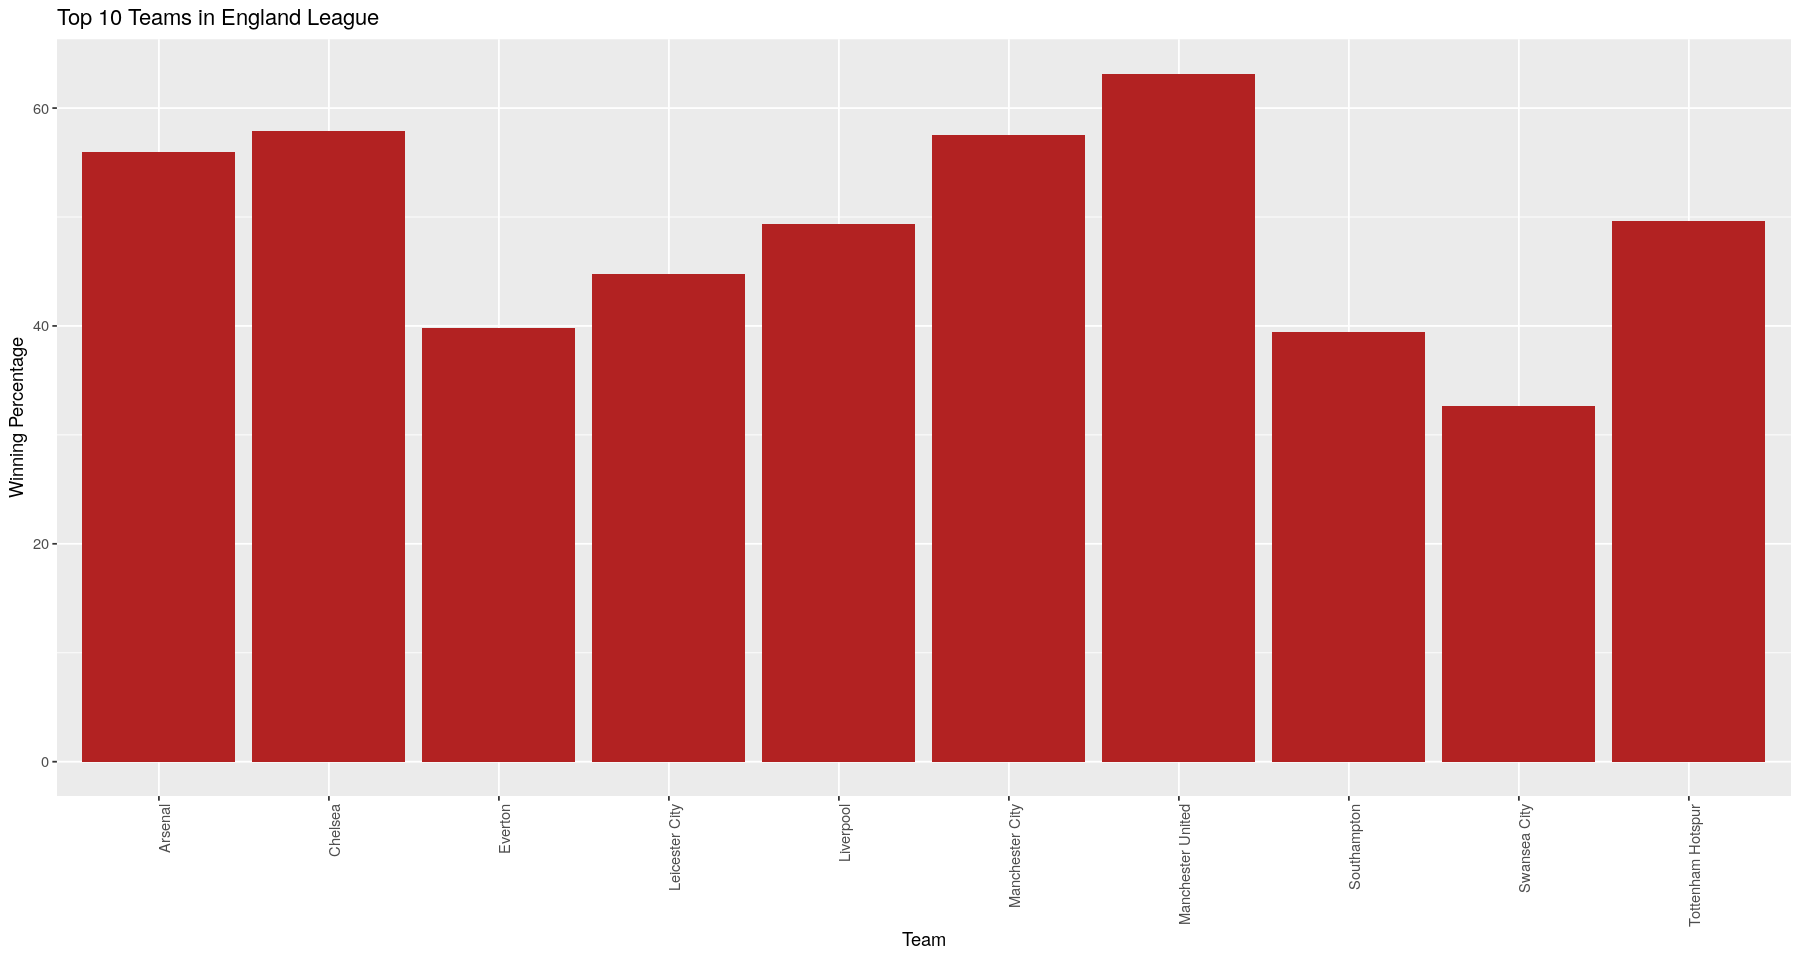

In [202]:
plot_top_teams(10, "England")

In [103]:
team_api_id <- dbGetQuery(db, "SELECT * FROM Team WHERE team_long_name LIKE '%Barcelona%'")$team_api_id

In [104]:
home_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE home_team_api_id = %s", team_api_id))
away_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE away_team_api_id = %s", team_api_id))

# remove fields with nulls
home_team_matches <- na.omit(home_team_matches)
away_team_matches <- na.omit(away_team_matches)

# get the player attributes closest to the date
get_player_attributes <- function(player_api_id, match_date = Sys.Date()) {
    versions <- Player[Player$player_api_id == player_api_id,]
    versions[order(abs(difftime(versions$date, match_date))),][1,]
}

In [105]:
get_player_attributes(30955, "2013-05-29")

,player_name,date,player_fifa_api_id,player_api_id,height,weight,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,⋯,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
12783,Andres Iniesta,2013-05-24 00:00:00,41,30955,170.18,150,90,right,high,medium,⋯,93,65,57,57,56,6,13,6,13,7


Standard deviations (1, .., p=4):
[1] 1.5902358 1.0558215 0.5317881 0.2712792

Rotation (n x k) = (4 x 4):
                       PC1          PC2         PC3         PC4
finishing       0.55718126 -0.297790842 -0.58599990 -0.50741875
dribbling       0.61354279  0.009228021 -0.09958359  0.78330275
shot_power      0.55835119  0.225806810  0.71809206 -0.34871052
standing_tackle 0.03685432  0.927494875 -0.36198208 -0.08581371

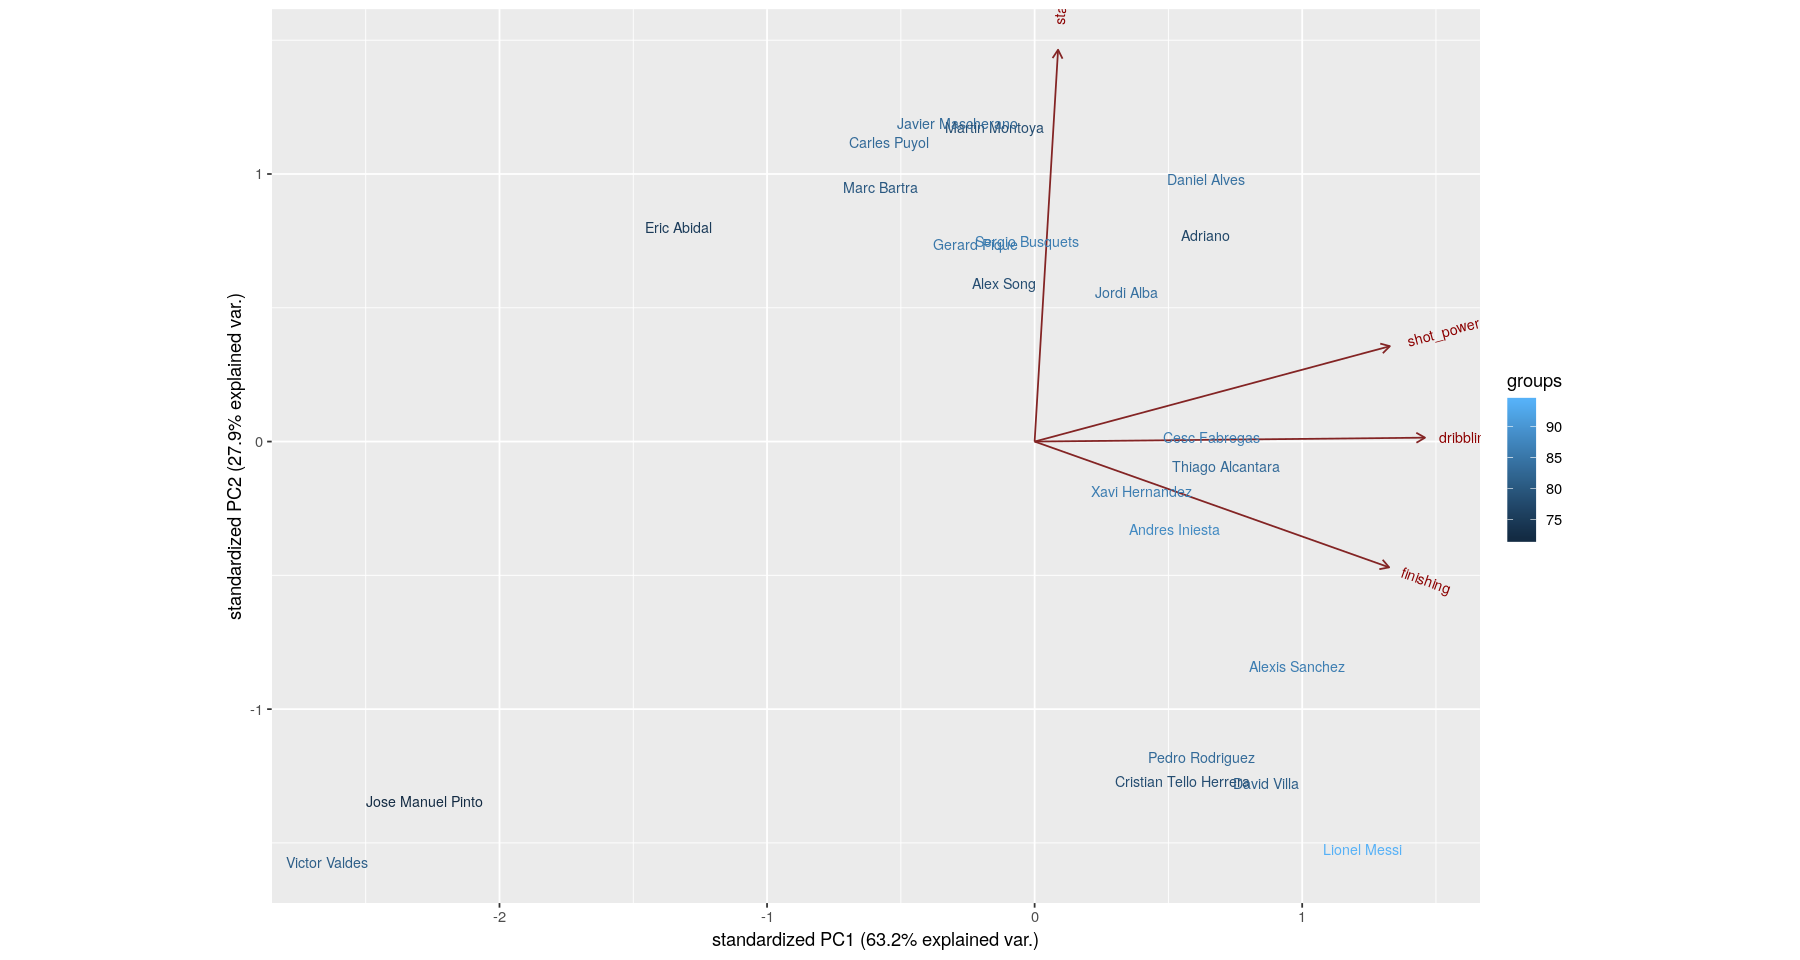

In [200]:
all_players <- list()
for (i in 1:11) {
    home_players <- as.list(home_team_matches[sprintf("home_player_%d", i)])
    away_players <- as.list(away_team_matches[sprintf("away_player_%d", i)])
    all_players <- append(unlist(all_players), unlist(home_players))
    all_players <- append(unlist(all_players), unlist(away_players))
}

all_players <- unique(all_players)
team_df <- do.call(rbind, Map(function(x) data.frame(get_player_attributes(x)), x=all_players))
pca <- prcomp(team_df[,c('finishing', 'dribbling', 'shot_power', 'standing_tackle')], center = TRUE,scale. = TRUE)
pca
library(ggbiplot)
ggbiplot(pca, labels=team_df$player_name, groups=team_df$overall_rating, repel=TRUE)

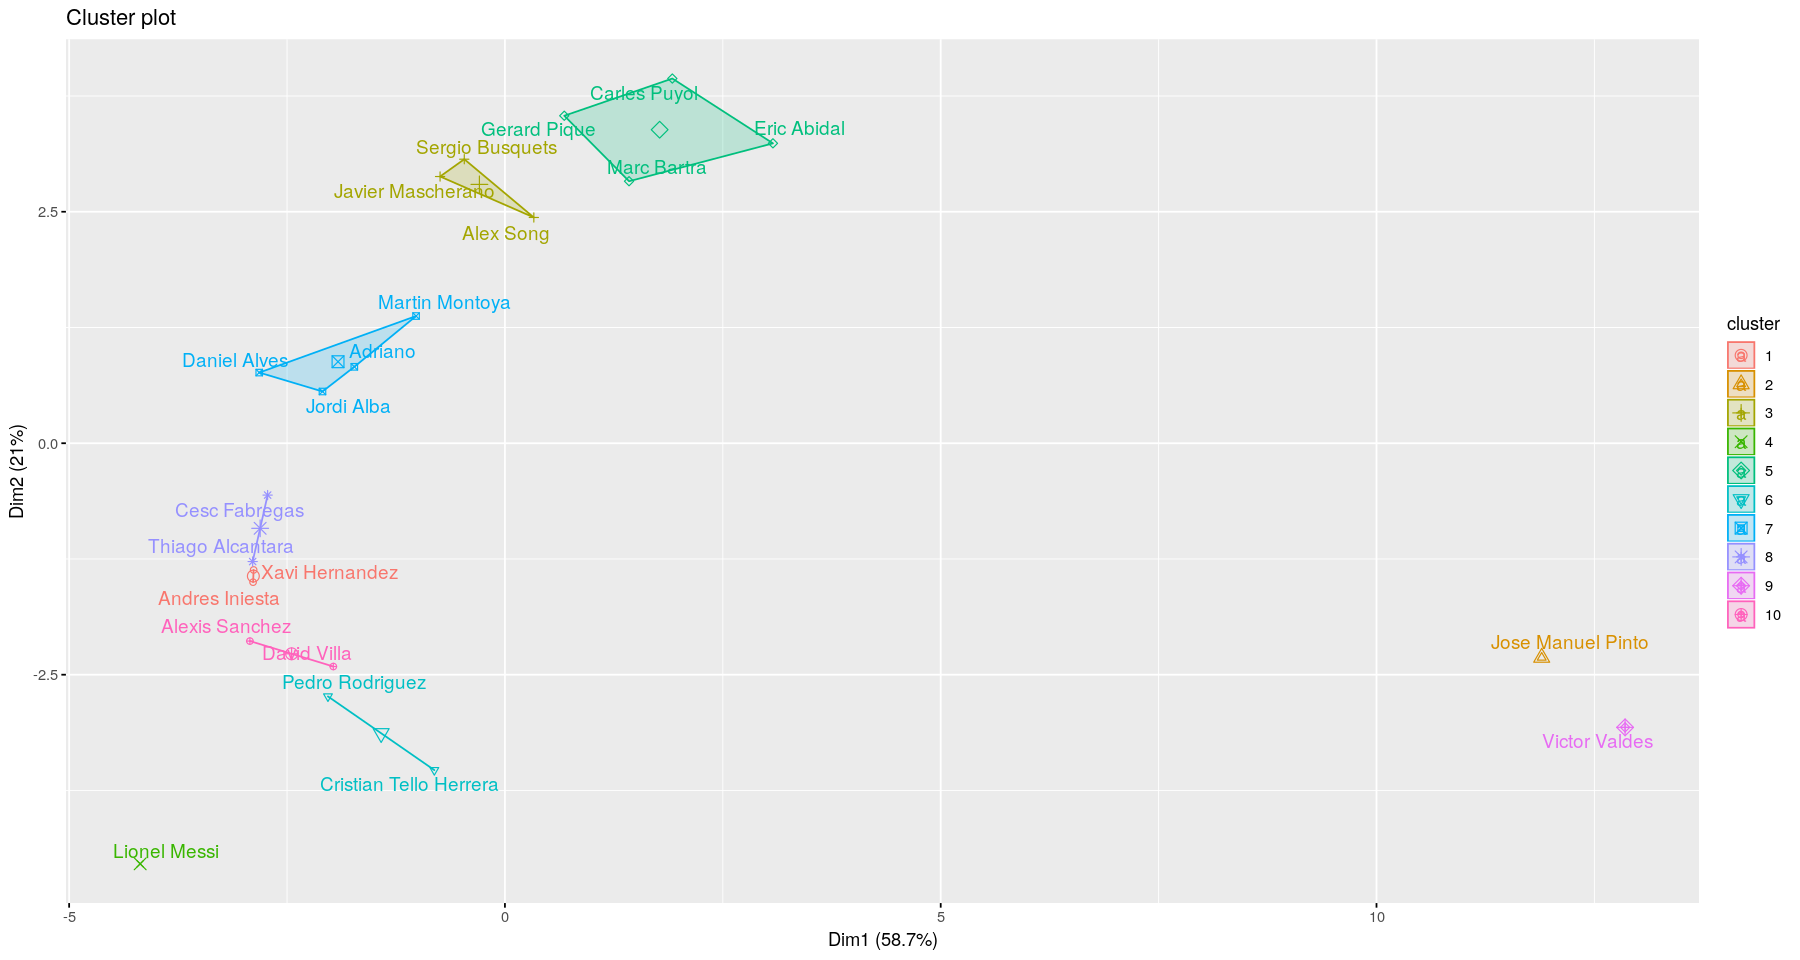

fviz_cluster {factoextra},R Documentation
object,"an object of class ""partition"" created by the functions pam(), clara() or fanny() in cluster package; ""kmeans"" [in stats package]; ""dbscan"" [in fpc package]; ""Mclust"" [in mclust]; ""hkmeans"", ""eclust"" [in factoextra]. Possible value are also any list object with data and cluster components (e.g.: object = list(data = mydata, cluster = myclust))."
data,the data that has been used for clustering. Required only when object is a class of kmeans or dbscan.
choose.vars,a character vector containing variables to be considered for plotting.
stand,"logical value; if TRUE, data is standardized before principal component analysis"
axes,a numeric vector of length 2 specifying the dimensions to be plotted.
geom,"a text specifying the geometry to be used for the graph. Allowed values are the combination of c(""point"", ""text""). Use ""point"" (to show only points); ""text"" to show only labels; c(""point"", ""text"") to show both types."
repel,"a boolean, whether to use ggrepel to avoid overplotting text labels or not."
show.clust.cent,"logical; if TRUE, shows cluster centers"
ellipse,"logical value; if TRUE, draws outline around points of each cluster"
ellipse.type,"Character specifying frame type. Possible values are 'convex', 'confidence' or types supported by stat_ellipse including one of c(""t"", ""norm"", ""euclid"")."


In [201]:
library(cluster)    # clustering algorithm
library(factoextra) # visualization
rownames(team_df) <- team_df$player_name
team_df[skill_stats] <- scale(team_df[skill_stats])
k5 <- kmeans(team_df[skill_stats], centers=10, nstart = 25)
fviz_cluster(k5, data = team_df, choose.vars=skill_stats, repel=TRUE) # prevent text overlapping
help(fviz_cluster)